# Code to calculate wind stress curl from VIKING20X output fields

## Technical preamble

In [1]:
%matplotlib inline
from datetime import datetime, timedelta
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import cmocean as co
import pandas as pd
import xarray as xr
from matplotlib import colors as c
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns

In [2]:
plt.rcParams['figure.figsize'] = [12, 14]
plt.rcParams.update({'font.size': 10})
years_fmt = mdates.DateFormatter('%Y-%m-%d')
sns.set_palette("colorblind")


## Experiment settings (user input)

### Parameters
These can be set in papermill

In [3]:
# location of input data
path_name = '/data/iAtlantic/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/'
experiment_name = 'VIKING20X.L46-KKG36107B' 
data_resolution = '1m'

# location of mask data
mask_path_name = '/data/iAtlantic/mask/VIKING20X.L46-KKG36107B/'
mesh_mask_filename = '1_mesh_mask.nc'
# location of output data
outpath_name = '../data/raw/'

year_prefix = 20  # this does from 2000 onwards


In [4]:
# names of files to load 
fname_U = f'1_{experiment_name}_{data_resolution}_{year_prefix}*_grid_U.nc'  
fname_V = f'1_{experiment_name}_{data_resolution}_{year_prefix}*_grid_V.nc'

data_path = Path(path_name)

mask_path = Path(mask_path_name)

outpath = Path(outpath_name)

In [5]:
degree2km = 1.852*60.0

## Construct input / output paths etc.

In [6]:
mesh_mask = mask_path / mesh_mask_filename

## Load input datasets

In [7]:
files_U = list(sorted((data_path).glob(fname_U)))
files_V = list(sorted((data_path).glob(fname_V)))
files_U

[PosixPath('/data/iAtlantic/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/1_VIKING20X.L46-KKG36107B_1m_20000101_20001231_grid_U.nc'),
 PosixPath('/data/iAtlantic/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/1_VIKING20X.L46-KKG36107B_1m_20010101_20011231_grid_U.nc'),
 PosixPath('/data/iAtlantic/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/1_VIKING20X.L46-KKG36107B_1m_20020101_20021231_grid_U.nc'),
 PosixPath('/data/iAtlantic/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/1_VIKING20X.L46-KKG36107B_1m_20030101_20031231_grid_U.nc'),
 PosixPath('/data/iAtlantic/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/1_VIKING20X.L46-KKG36107B_1m_20040101_20041231_grid_U.nc'),
 PosixPath('/data/iAtlantic/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/1_VIKING20X.L46-KKG36107B_1m_20050101_20051231_grid_U.nc'),
 PosixPath('/data/iAtlantic/ocean-only/VIKING20X.L46-KKG36107B/nemo/output/1_VIKING20X.L46-KKG36107B_1m_20060101_20061231_grid_U.nc'),
 PosixPath('/data/iAtlantic/ocean-only/VIKING20X.L46-KK

In [8]:
ds_mask = xr.open_dataset(mesh_mask)
# gridU = xr.open_dataset(files_U[0])
# gridV = xr.open_dataset(files_V[0])
gridU = xr.open_mfdataset(files_U,
    combine='by_coords', concat_dim='time_counter', data_vars='minimal'
)
gridV = xr.open_mfdataset(files_V,
    combine='by_coords', concat_dim='time_counter', data_vars='minimal'
)


In [9]:
fmask=ds_mask.fmask.isel(z=0)

In [10]:
taux=gridU.sozotaux.where(fmask==1)
tauy=gridV.sometauy.where(fmask==1)


In [11]:
dtauxbydy = ((taux.shift(y=-1)-taux)/(ds_mask.e2f))

In [12]:
dtauybydx = ((tauy.shift(x=-1)-tauy)/(ds_mask.e1f))

In [13]:
curl_tau = dtauybydx - dtauxbydy

In [14]:
curl_tau_mean = curl_tau.mean(dim='time_counter',skipna=True).compute()

/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [21]:
# 9-cell mean
curl_tau_smooth = curl_tau.rolling(x=19,min_periods=10,center=True).mean()
curl_tau_smooth = curl_tau_smooth.rolling(y=19,min_periods=10,center=True).mean()


In [22]:
curl_tau_smooth_mean = curl_tau_smooth.mean(dim='time_counter',skipna=True).compute()

/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [47]:
winter = [0,1,2,
          12,13,14,
          24,25,26,
          36,37,38,
          48,49,50,
          60,61,62,
          72,73,74,
          84,85,86,
          96,97,98,
          108,109,110,
          120,121,122,
          132,133,134,
          144,145,146,
          156,157,158,
          168,169,170,
          180,181,182,
          192,193,194,
          204,205,206,
          216,217,218]
curl_tau_mean_winter = curl_tau.isel(time_counter=winter).mean(dim='time_counter',skipna=True).compute()
curl_tau_smooth_mean_winter = curl_tau_smooth.isel(time_counter=winter).mean(dim='time_counter',skipna=True).compute()


/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [24]:
def draw_panel(i,ax,tmin,tmax,curl_tau):
    cs = ax.contourf(ds_mask.glamf,
                     ds_mask.gphif,
                     curl_tau.isel(time_counter=slice(tmin,tmax,1)).mean(dim='time_counter')*1.0e7,
                     cmap=co.cm.curl,
                     levels=np.arange(-5,5.1,0.1),
                     extend='both')
    ax.text(1,0, str(i),
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax.transAxes)
    return cs

In [27]:
def draw_panel_anomaly(i,ax,tmin,tmax,curl_tau,curl_mean):
    anomaly = (curl_tau-curl_mean).isel(time_counter=slice(tmin,tmax,1))
    anomaly = anomaly.mean(dim='time_counter')*1.0e7
    cs = ax.contourf(ds_mask.glamf,
                     ds_mask.gphif,
                     anomaly,
                     cmap=co.cm.curl,
                     levels=np.arange(-5,5.1,0.1),
                     extend='both')
    ax.text(1,0, str(i),
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax.transAxes)
    return cs

In [49]:
def draw_panel_anomaly_lowres(i,ax,tmin,tmax,curl_tau,curl_mean):
    anomaly = (curl_tau.isel(x=slice(10,-1,20),y=slice(10,-1,20))-curl_mean.isel(x=slice(10,-1,20),y=slice(10,-1,20))).isel(time_counter=slice(tmin,tmax,1))
    anomaly = anomaly.mean(dim='time_counter')*1.0e7
    cs = ax.contourf(ds_mask.isel(x=slice(10,-1,20),y=slice(10,-1,20)).glamf,
                     ds_mask.isel(x=slice(10,-1,20),y=slice(10,-1,20)).gphif,
                     anomaly,
                     cmap=co.cm.curl,
                     levels=np.arange(-3,3.1,0.5),
                     extend='both')
    ax.text(1,0, str(i),
        horizontalalignment='right',
        verticalalignment='bottom',
        transform=ax.transAxes)
    return cs

/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

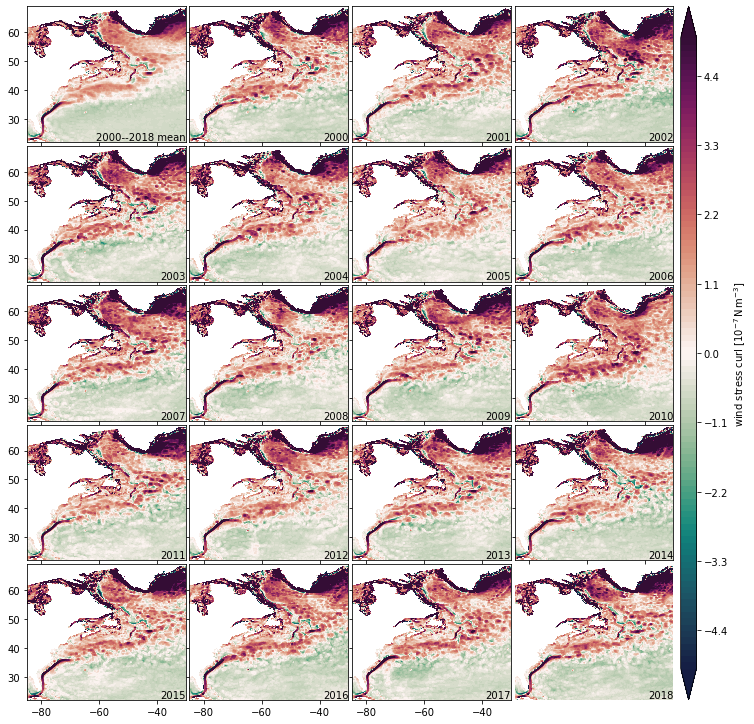

In [18]:
nrows = 5
ncols = 4

fig = plt.figure(figsize=(12,15))
grid = ImageGrid(fig, 111,
                nrows_ncols=(nrows, ncols),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_size='2%',
                cbar_location='right',
                cbar_pad=0.1
                )
# plot long term mean first
grid[0].contourf(ds_mask.glamf,
                 ds_mask.gphif,
                 (curl_tau_mean)*1.0e7,
                 cmap=co.cm.curl,
                 levels=np.arange(-5,5.1,0.1),
                 extend='both')
grid[0].text(1,0, '2000--2018 mean',
    horizontalalignment='right',
    verticalalignment='bottom',
    transform=grid[0].transAxes)


for i in range(2000,2019):
    n=i-2000
    npanel=n+1
    mstart = n * 12
    mend = mstart + 12
    cs = draw_panel(i,grid[npanel],mstart,mend,curl_tau)

grid[19].axis('off')

plt.colorbar(cs,cax=grid.cbar_axes[0],label=r'wind stress curl [$10^{-7}\, \mathrm{N\,m^{-3}}$]')

custom_xlim = (-85, -30)
custom_ylim = (22, 69)
plt.setp(grid, xlim=custom_xlim, ylim=custom_ylim)
plt.savefig('tau_annualmean.png')

/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


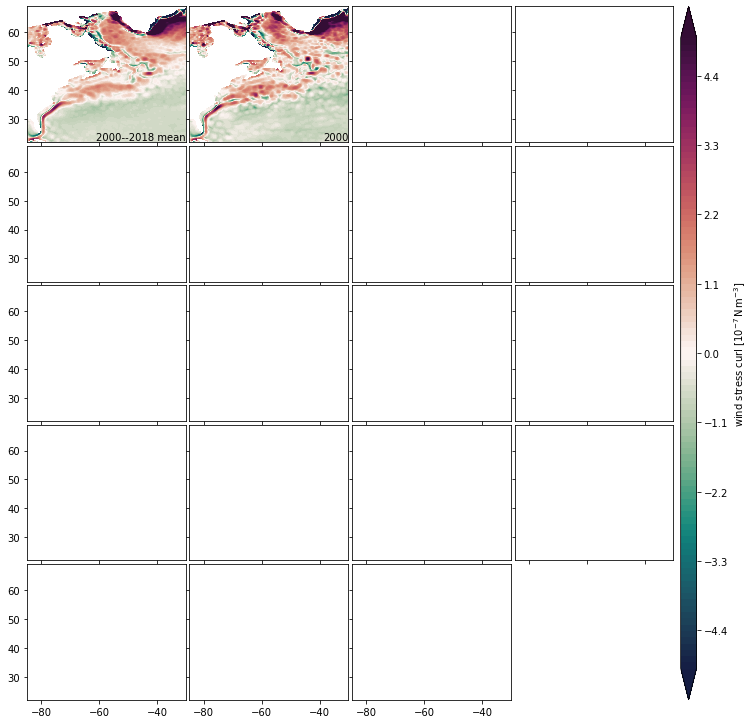

In [26]:
nrows = 5
ncols = 4

fig = plt.figure(figsize=(12,15))
grid = ImageGrid(fig, 111,
                nrows_ncols=(nrows, ncols),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_size='2%',
                cbar_location='right',
                cbar_pad=0.1
                )
# plot long term mean first
grid[0].contourf(ds_mask.glamf,
                 ds_mask.gphif,
                 (curl_tau_smooth_mean)*1.0e7,
                 cmap=co.cm.curl,
                 levels=np.arange(-5,5.1,0.1),
                 extend='both')
grid[0].text(1,0, '2000--2018 mean',
    horizontalalignment='right',
    verticalalignment='bottom',
    transform=grid[0].transAxes)


for i in range(2000,2001):
    n=i-2000
    npanel=n+1
    mstart = n * 12
    mend = mstart + 12
    cs = draw_panel(i,grid[npanel],mstart,mend,curl_tau_smooth)

grid[19].axis('off')

plt.colorbar(cs,cax=grid.cbar_axes[0],label=r'wind stress curl [$10^{-7}\, \mathrm{N\,m^{-3}}$]')

custom_xlim = (-85, -30)
custom_ylim = (22, 69)
plt.setp(grid, xlim=custom_xlim, ylim=custom_ylim)
plt.savefig('tau_smooth_annualmean.png')

/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


KeyboardInterrupt: 

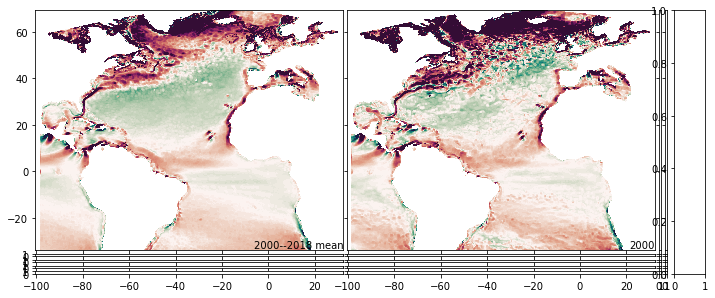

In [19]:
nrows = 5
ncols = 4

fig = plt.figure(figsize=(12,15))
grid = ImageGrid(fig, 111,
                nrows_ncols=(nrows, ncols),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_size='2%',
                cbar_location='right',
                cbar_pad=0.1
                )
# plot long term mean first
grid[0].contourf(ds_mask.glamf,
                 ds_mask.gphif,
                 (curl_tau_mean_winter)*1.0e7,
                 cmap=co.cm.curl,
                 levels=np.arange(-5,5.1,0.1),
                 extend='both')
grid[0].text(1,0, '2000--2018 mean',
    horizontalalignment='right',
    verticalalignment='bottom',
    transform=grid[0].transAxes)


for i in range(2000,2019):
    n=i-2000
    npanel=n+1
    mstart = n * 12
    mend = mstart + 2
    cs = draw_panel(i,grid[npanel],mstart,mend)

grid[19].axis('off')

plt.colorbar(cs,cax=grid.cbar_axes[0],label=r'wind stress curl [$10^{-7}\, \mathrm{N\,m^{-3}}$]')

custom_xlim = (-85, -30)
custom_ylim = (22, 69)
plt.setp(grid, xlim=custom_xlim, ylim=custom_ylim)
plt.savefig('tau_janfebmean.png')

/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


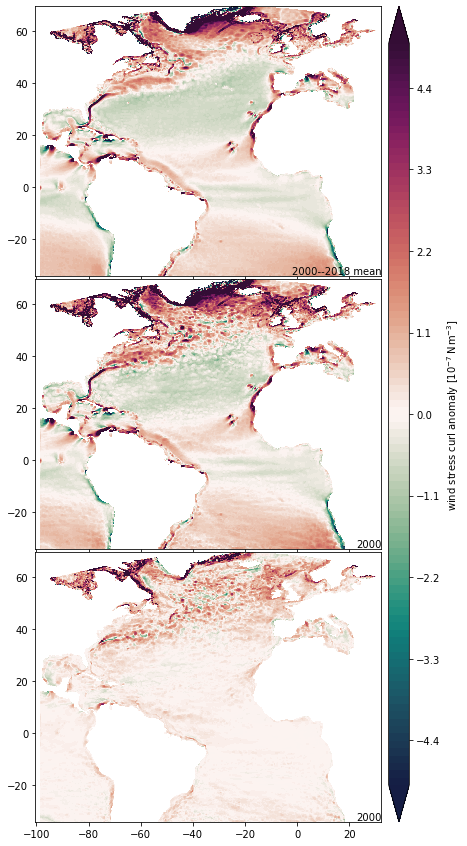

In [43]:
nrows = 3
ncols = 1

fig = plt.figure(figsize=(10,15))
grid = ImageGrid(fig, 111,
                nrows_ncols=(nrows, ncols),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_size='2%',
                cbar_location='right',
                cbar_pad=0.1
                )
# plot long term mean first
cs=grid[0].contourf(ds_mask.glamf,
                 ds_mask.gphif,
                 (curl_tau_mean)*1.0e7,
                 cmap=co.cm.curl,
                 levels=np.arange(-5,5.1,0.1),
                 extend='both')
grid[0].text(1,0, '2000--2018 mean',
    horizontalalignment='right',
    verticalalignment='bottom',
    transform=grid[0].transAxes)

# now plot single year
for i in range(2000,2001):
    n=i-2000
    npanel=n+1
    mstart = n * 12
    mend = mstart + 12
    cs = draw_panel(i,grid[npanel],mstart,mend,curl_tau)
# now plot anomalies
for i in range(2000,2001):
    n=i-2000
    npanel=n+2
    mstart = n * 12
    mend = mstart + 12
    cs = draw_panel_anomaly(i,grid[npanel],mstart,mend,curl_tau,curl_tau_mean)

plt.colorbar(cs,cax=grid.cbar_axes[0],label=r'wind stress curl anomaly [$10^{-7}\, \mathrm{N\,m^{-3}}$]')

# custom_xlim = (-85, -30)
# custom_ylim = (22, 69)
# plt.setp(grid, xlim=custom_xlim, ylim=custom_ylim)
plt.savefig('tau_annualmean_anomaly_2.png')

/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


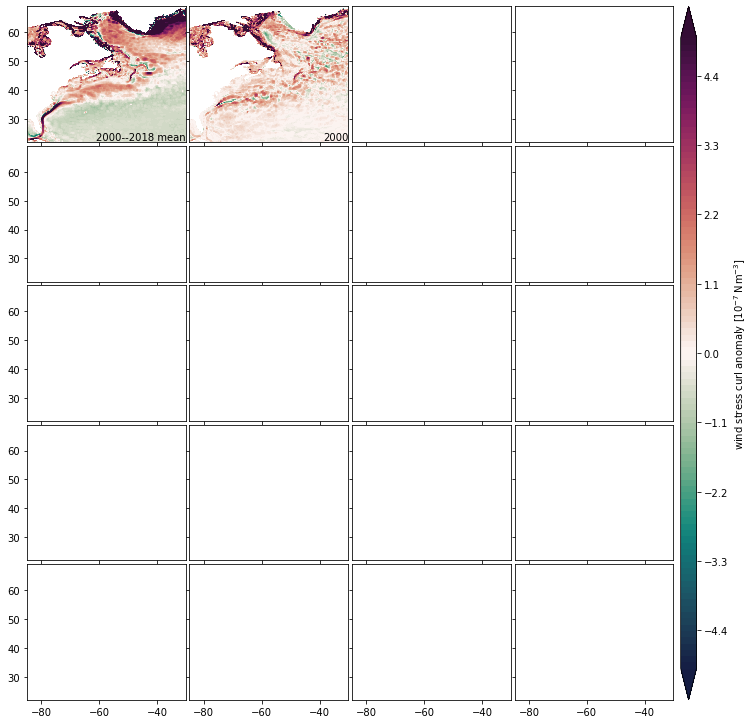

In [29]:
nrows = 5
ncols = 4

fig = plt.figure(figsize=(12,15))
grid = ImageGrid(fig, 111,
                nrows_ncols=(nrows, ncols),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_size='2%',
                cbar_location='right',
                cbar_pad=0.1
                )
# plot long term mean first
cs=grid[0].contourf(ds_mask.glamf,
                 ds_mask.gphif,
                 (curl_tau_mean)*1.0e7,
                 cmap=co.cm.curl,
                 levels=np.arange(-5,5.1,0.1),
                 extend='both')
grid[0].text(1,0, '2000--2018 mean',
    horizontalalignment='right',
    verticalalignment='bottom',
    transform=grid[0].transAxes)

# now plot anomalies
for i in range(2000,2001):
    n=i-2000
    npanel=n+1
    mstart = n * 12
    mend = mstart + 12
    cs = draw_panel_anomaly(i,grid[npanel],mstart,mend,curl_tau,curl_tau_mean)

plt.colorbar(cs,cax=grid.cbar_axes[0],label=r'wind stress curl anomaly [$10^{-7}\, \mathrm{N\,m^{-3}}$]')

custom_xlim = (-85, -30)
custom_ylim = (22, 69)
plt.setp(grid, xlim=custom_xlim, ylim=custom_ylim)
plt.savefig('tau_annualmean_anomaly.png')

/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


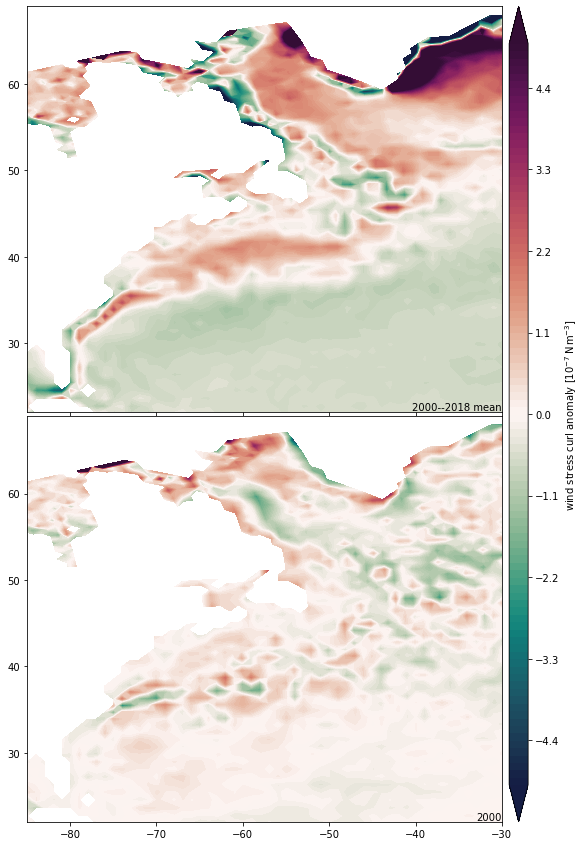

In [37]:
nrows = 2
ncols = 1

fig = plt.figure(figsize=(10,15))
grid = ImageGrid(fig, 111,
                nrows_ncols=(nrows, ncols),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_size='2%',
                cbar_location='right',
                cbar_pad=0.1
                )
# plot long term mean first
cs=grid[0].contourf(ds_mask.isel(x=slice(10,-1,20),y=slice(10,-1,20)).glamf,
                 ds_mask.isel(x=slice(10,-1,20),y=slice(10,-1,20)).gphif,
                 (curl_tau_smooth_mean.isel(x=slice(10,-1,20),y=slice(10,-1,20)))*1.0e7,
                 cmap=co.cm.curl,
                 levels=np.arange(-5,5.1,0.1),
                 extend='both')
grid[0].text(1,0, '2000--2018 mean',
    horizontalalignment='right',
    verticalalignment='bottom',
    transform=grid[0].transAxes)

# now plot anomalies
for i in range(2000,2001):
    n=i-2000
    npanel=n+1
    mstart = n * 12
    mend = mstart + 12
    cs = draw_panel_anomaly_lowres(i,grid[npanel],mstart,mend,curl_tau_smooth,curl_tau_smooth_mean)

plt.colorbar(cs,cax=grid.cbar_axes[0],label=r'wind stress curl anomaly [$10^{-7}\, \mathrm{N\,m^{-3}}$]')

custom_xlim = (-85, -30)
custom_ylim = (22, 69)
plt.setp(grid, xlim=custom_xlim, ylim=custom_ylim)
plt.savefig('tau_smooth_annualmean_anomaly_2.png')

In [ ]:
nrows = 5
ncols = 4

fig = plt.figure(figsize=(12,15))
grid = ImageGrid(fig, 111,
                nrows_ncols=(nrows, ncols),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_size='2%',
                cbar_location='right',
                cbar_pad=0.1
                )
# plot long term mean first
cs=grid[0].contourf(ds_mask.isel(x=slice(10,-1,20),y=slice(10,-1,20)).glamf,
                 ds_mask.isel(x=slice(10,-1,20),y=slice(10,-1,20)).gphif,
                 (curl_tau_smooth_mean.isel(x=slice(10,-1,20),y=slice(10,-1,20)))*1.0e7,
                 cmap=co.cm.curl,
                 levels=np.arange(-3,3.1,0.5),
                 extend='both')
grid[0].text(1,0, '2000--2018 mean',
    horizontalalignment='right',
    verticalalignment='bottom',
    transform=grid[0].transAxes)

# now plot anomalies
for i in range(2000,2019):
    n=i-2000
    npanel=n+1
    mstart = n * 12
    mend = mstart + 12
    cs = draw_panel_anomaly_lowres(i,grid[npanel],mstart,mend,curl_tau_smooth,curl_tau_smooth_mean)

plt.colorbar(cs,cax=grid.cbar_axes[0],label=r'wind stress curl anomaly [$10^{-7}\, \mathrm{N\,m^{-3}}$]')

custom_xlim = (-85, -2)
custom_ylim = (21, 69)
plt.setp(grid, xlim=custom_xlim, ylim=custom_ylim)
for i in range(0,20):
    grid[i].set_aspect(1.5)
plt.savefig('curl_tau_smooth_lowres_annualmean_anomaly.png')

/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

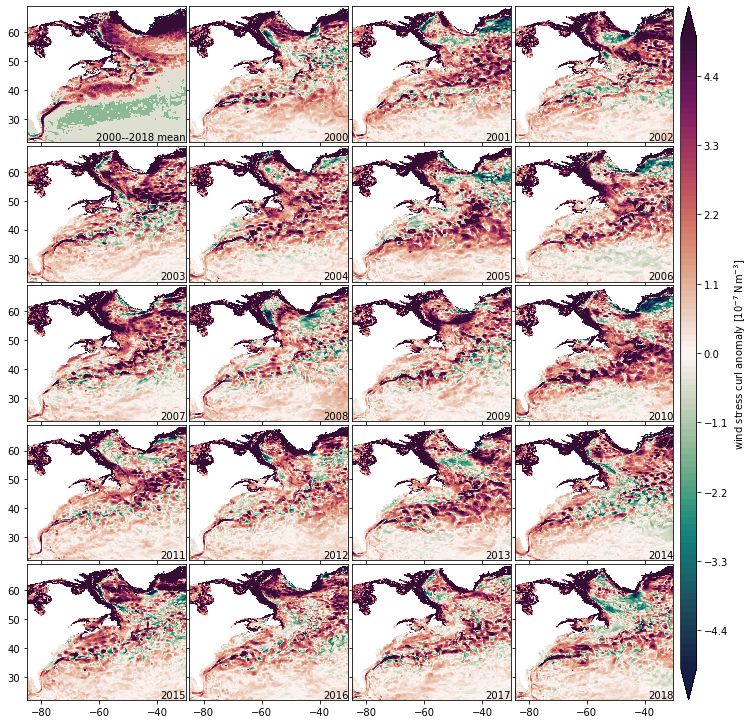

In [45]:
nrows = 5
ncols = 4

fig = plt.figure(figsize=(12,15))
grid = ImageGrid(fig, 111,
                nrows_ncols=(nrows, ncols),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_size='2%',
                cbar_location='right',
                cbar_pad=0.1
                )
# plot long term mean first
cs=grid[0].contourf(ds_mask.glamf,
                 ds_mask.gphif,
                 (curl_tau_mean_winter)*1.0e7,
                 cmap=co.cm.curl,
                 levels=np.arange(-5,5.1,1),
                 extend='both')
grid[0].text(1,0, '2000--2018 mean',
    horizontalalignment='right',
    verticalalignment='bottom',
    transform=grid[0].transAxes)

# now plot anomalies
for i in range(2000,2019):
    n=i-2000
    npanel=n+1
    mstart = n * 12
    mend = mstart + 3
    cs = draw_panel_anomaly(i,grid[npanel],mstart,mend,curl_tau,curl_tau_mean_winter)

plt.colorbar(cs,cax=grid.cbar_axes[0],label=r'wind stress curl anomaly [$10^{-7}\, \mathrm{N\,m^{-3}}$]')

custom_xlim = (-85, -30)
custom_ylim = (22, 69)
plt.setp(grid, xlim=custom_xlim, ylim=custom_ylim)
plt.savefig('tau_janfebmean_anomaly.png')

/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/opt/tljh/user/envs/parcels-container_2021.03.17-6c459b7/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1,

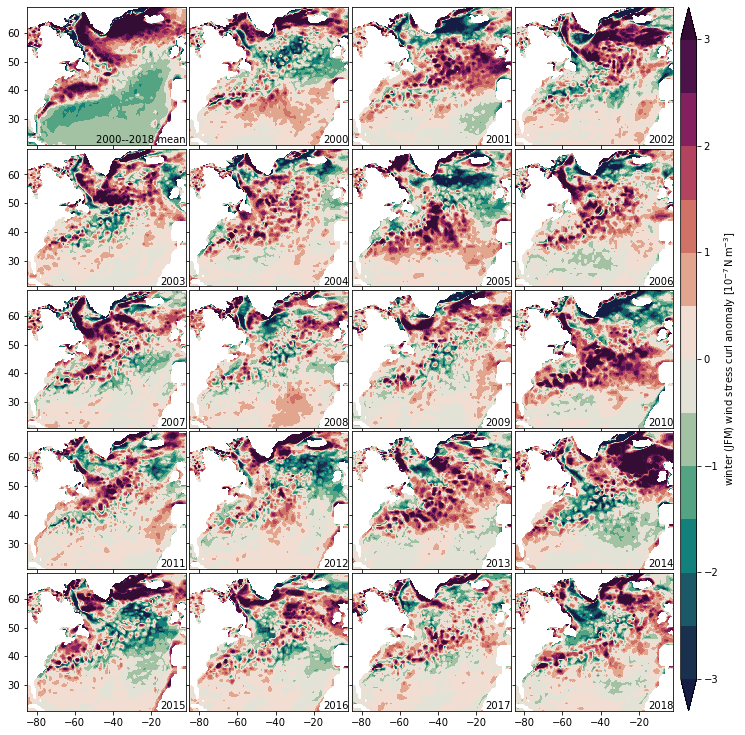

In [56]:
nrows = 5
ncols = 4

fig = plt.figure(figsize=(12,15))
grid = ImageGrid(fig, 111,
                nrows_ncols=(nrows, ncols),
                axes_pad=0.05,
                cbar_mode='single',
                cbar_size='2%',
                cbar_location='right',
                cbar_pad=0.1
                )
# plot long term mean first
cs=grid[0].contourf(ds_mask.isel(x=slice(10,-1,20),y=slice(10,-1,20)).glamf,
                 ds_mask.isel(x=slice(10,-1,20),y=slice(10,-1,20)).gphif,
                 (curl_tau_smooth_mean_winter.isel(x=slice(10,-1,20),y=slice(10,-1,20)))*1.0e7,
                 cmap=co.cm.curl,
                 levels=np.arange(-3,3.1,0.5),
                 extend='both')
grid[0].text(1,0, '2000--2018 mean',
    horizontalalignment='right',
    verticalalignment='bottom',
    transform=grid[0].transAxes)

# now plot anomalies
for i in range(2000,2019):
    n=i-2000
    npanel=n+1
    mstart = n * 12
    mend = mstart + 3
    cs = draw_panel_anomaly_lowres(i,grid[npanel],mstart,mend,curl_tau_smooth,curl_tau_smooth_mean_winter)

plt.colorbar(cs,cax=grid.cbar_axes[0],label=r'winter (JFM) wind stress curl anomaly [$10^{-7}\, \mathrm{N\,m^{-3}}$]')

custom_xlim = (-85, -2)
custom_ylim = (21, 69)
plt.setp(grid, xlim=custom_xlim, ylim=custom_ylim)
for i in range(0, 20):
    grid[i].set_aspect(1.5)
plt.savefig('curl_tau_smooth_lowres_annualmean_anomaly_winter.png')

In [ ]:
conda list


In [ ]:
pip list
